In [1]:
import warnings
warnings.filterwarnings(action='ignore')

import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import joblib 
from sklearn.metrics import make_scorer

# 시계열
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error

from datetime import datetime as dt
from statsmodels.tsa.arima_model import ARIMA
from dateutil.relativedelta import relativedelta
from statsmodels.tsa.api import SimpleExpSmoothing, Holt, ExponentialSmoothing
from sklearn.metrics import r2_score

In [2]:
# 매출 TR 데이터 READ

df = pd.read_csv('./data/TRD.txt', delimiter = '\t')
df.head()

,SALE_YMD,GOODS_CD,SLPRC_UNTPRC,SALE_QTY
0,2017-01-02,6436568,8500,3
1,2017-01-02,3364277,6200,2
2,2017-01-02,1562415,1400,5
3,2017-01-02,6726263,2500,7
4,2017-01-02,1558500,2100,2


In [3]:
df['SALE_AMT'] = df['SLPRC_UNTPRC'] * df['SALE_QTY']
df = df[{'SALE_YMD','SALE_AMT'}]
df = df[(df['SALE_YMD']>'2018-01-00') & (df['SALE_YMD']<'2020-04-00')].groupby('SALE_YMD',as_index=False).sum()

df

,SALE_YMD,SALE_AMT
0,2018-01-02,7166110
1,2018-01-03,7451660
2,2018-01-04,5960830
3,2018-01-05,5919560
4,2018-01-06,7249570
...,...,...
792,2020-03-27,5518650
793,2020-03-28,6131920
794,2020-03-29,5540410
795,2020-03-30,5192370


In [4]:
# Nan 확인

train_info = [(col, len(df[col].unique()), df[col].isnull().sum(), df[col].dtype, df[col].unique()[:5]) for col in df.columns]
train_df_info = pd.DataFrame(train_info, columns=['name', 'num_of_unique', 'num_of_nan', 'type', 'front5_values'])
train_df_info

,name,num_of_unique,num_of_nan,type,front5_values
0,SALE_YMD,797,0,object,"[2018-01-02, 2018-01-03, 2018-01-04, 2018-01-0..."
1,SALE_AMT,797,0,int64,"[7166110, 7451660, 5960830, 5919560, 7249570]"


In [5]:
# Plot Graph

def plot_model_graph(data_frame, idx_col, y_cols):
    
    data_frame = data_frame.set_index(idx_col, drop=True, append=False, inplace = False)

    fig, ax1 = plt.subplots(figsize=(15, 3))
    ax1.set_xlabel("{}".format(idx_col))
    ax1.set_ylabel("{}".format(y_cols[0])).set_color(color='tab:blue')
    ax1.plot(data_frame.index, data_frame[y_cols[0]].values, color='tab:blue')
    
    for i in range(1, len(y_cols)):
        ax2 = ax1.twinx()
        ax2.set_ylabel("{}".format(y_cols[i])).set_color(color='C{}'.format(i))
        ax2.plot(data_frame.index, data_frame[y_cols[i]].values, color='C{}'.format(i))
        ax2.spines['right'].set_position(('outward', (60*(i-1))))

    fig.tight_layout()
    plt.show()

In [6]:
df_2018_1 = df[(df['SALE_YMD'] > '2018-01-00') & (df['SALE_YMD'] < '2018-06-00')]
df_2018_2 = df[(df['SALE_YMD'] > '2018-06-00') & (df['SALE_YMD'] < '2019-01-00')]
df_2019_1 = df[(df['SALE_YMD'] > '2019-01-00') & (df['SALE_YMD'] < '2019-06-00')]
df_2019_2 = df[(df['SALE_YMD'] > '2019-06-00') & (df['SALE_YMD'] < '2020-01-00')]
df_2020_1 = df[(df['SALE_YMD'] > '2020-01-00') & (df['SALE_YMD'] < '2020-06-00')]

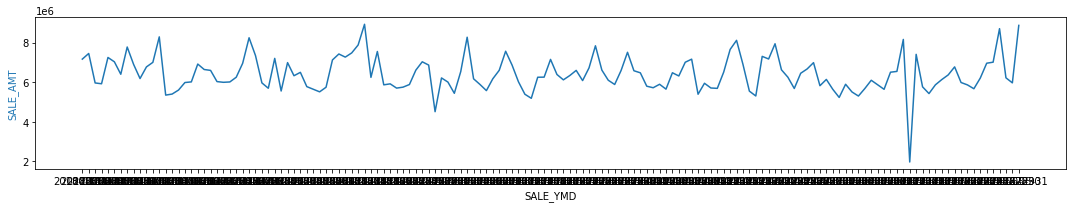

In [7]:
plot_model_graph(df_2018_1, 'SALE_YMD', ['SALE_AMT'])

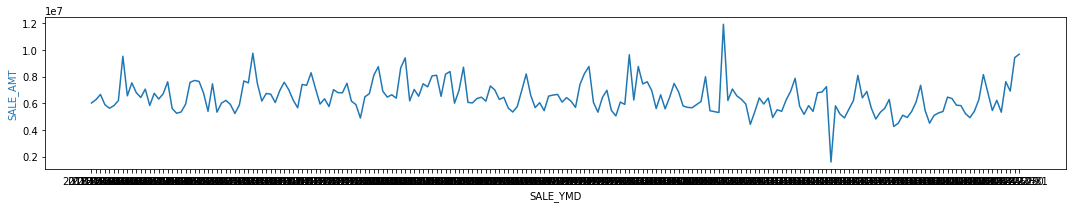

In [8]:
plot_model_graph(df_2018_2, 'SALE_YMD', ['SALE_AMT'])

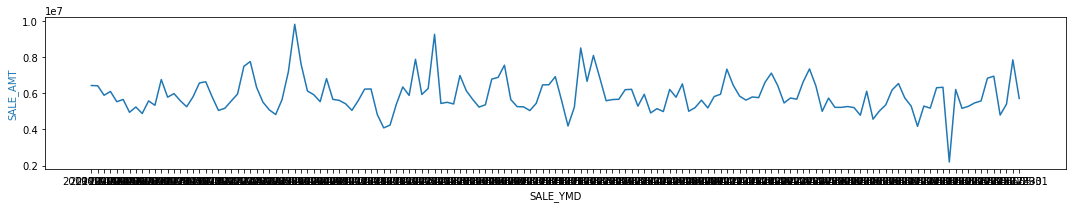

In [9]:
plot_model_graph(df_2019_1, 'SALE_YMD', ['SALE_AMT'])

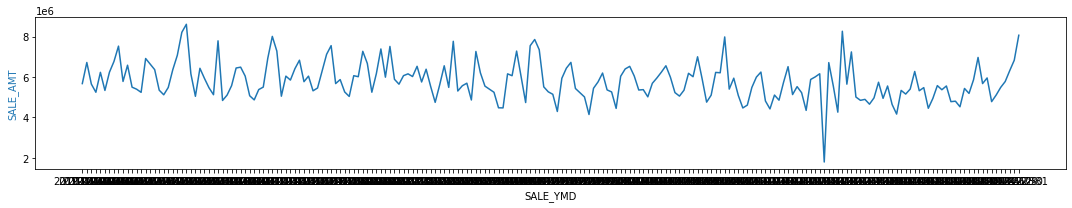

In [10]:
plot_model_graph(df_2019_2, 'SALE_YMD', ['SALE_AMT'])

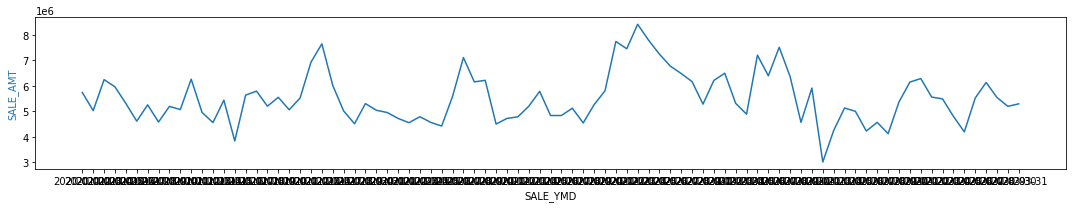

In [11]:
plot_model_graph(df_2020_1, 'SALE_YMD', ['SALE_AMT'])

In [12]:
df.to_csv('./data/pre_data_tr.csv', index=False)
df_date_sum = df.copy()

Simple Moving Average

In [13]:
def make_sma_arr(dataframe, col, start, window):
    result = pd.DataFrame(columns = ['index','r2'])
    result2 = dataframe.copy()

    for i in range(start,window+1):
        pred = pd.DataFrame()
        sma_month = pd.DataFrame()

        sma_month['MA'] = pd.Series.rolling(dataframe[col],window=i, center=False).mean()
        pred['pred'] = sma_month['MA'].shift(1)
        st = pred.apply(pd.Series.first_valid_index)
        y = dataframe[col][st[0]:]
        y_pred = sma_month['MA'][st[0]:]
        #rmse = mean_squared_error(y, y_pred)**0.5
        r2 = r2_score(y,y_pred)
        result = result.append({'index': "{0:.0f}".format(i),'r2':"{0:.03f}".format(r2)}, ignore_index=True)
        result2.insert(i, str(i)+"ma",sma_month['MA'])
    
    return result, result2

In [14]:
# 이동평균 window size 2, 3, 4
result, result2 = make_sma_arr(df_date_sum, 'SALE_AMT',2,4)

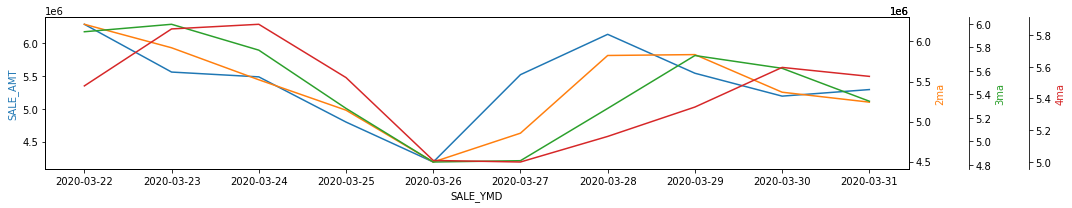

In [15]:
# 이동평균으로 예측한 결과와 실제 결과 비교
plot_model_graph(result2.tail(10), 'SALE_YMD', ['SALE_AMT','2ma','3ma','4ma'])

In [16]:
# 이동평균으로 예측한 결과와 실제값의 r2 score
result

,index,r2
0,2,0.688
1,3,0.510
2,4,0.379


Exponential Moving Average

In [17]:
def make_emw_arr(dataframe, col, start, window):
    result = pd.DataFrame(columns = ['index','r2'])
    result2 = dataframe.copy()

    for i in range(start,window+1):
        pred = pd.DataFrame()
        sma_month = pd.DataFrame()

        sma_month['MA'] = dataframe[col].ewm(span=i).mean().values
        pred['pred'] = sma_month['MA'].shift(1)
        st = pred.apply(pd.Series.first_valid_index)
        y = dataframe[col][st[0]:]
        y_pred = sma_month['MA'][st[0]:]
        #rmse = mean_squared_error(y, y_pred)**0.5
        r2 = r2_score(y,y_pred)
        result = result.append({'index': "{0:.0f}".format(i),'r2':"{0:.03f}".format(r2)}, ignore_index=True)
        result2.insert(i, str(i)+"ew",sma_month['MA'])
    
    return result, result2

In [18]:
# 단순지수평활 window size 2, 3, 4
result, result2 = make_emw_arr(df_date_sum, 'SALE_AMT',2,4)

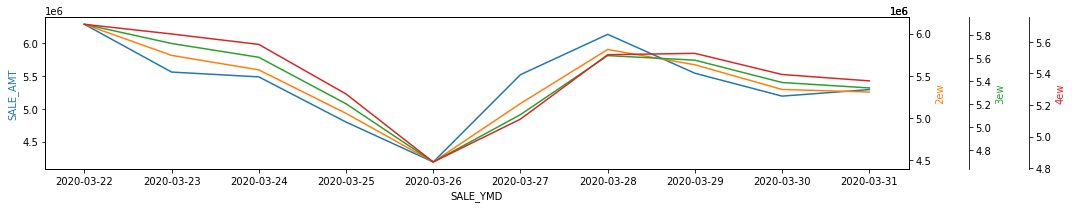

In [19]:
# 단순지수평활로 예측한 결과와 실제 결과 비교
plot_model_graph(result2.tail(10), 'SALE_YMD', ['SALE_AMT','2ew','3ew','4ew'])

In [20]:
# 단순지수평활로 예측한 결과와 실제값의 r2 score
result

,index,r2
0,2,0.884
1,3,0.755
2,4,0.657


Simple Exponential Smoothing

In [21]:
ssm1=SimpleExpSmoothing(df_date_sum.SALE_AMT).fit(smoothing_level=0.05,optimized=False)
ssm2=SimpleExpSmoothing(df_date_sum.SALE_AMT).fit(smoothing_level=0.3,optimized=False)
ssm0=SimpleExpSmoothing(df_date_sum.SALE_AMT).fit()
print('optimal alpha',ssm0.model.params['smoothing_level'])

optimal alpha 0.056631522316625604


In [22]:
result = pd.DataFrame(columns = ['index','r2'])
result2 = df_date_sum.copy()
y = result2.SALE_AMT
y_pred0 = ssm0.fittedvalues
y_pred1 = ssm1.fittedvalues
y_pred2 = ssm2.fittedvalues
#rmse0 = mean_squared_error(y, y_pred0)**0.5
#rmse1 = mean_squared_error(y, y_pred1)**0.5
#rmse2 = mean_squared_error(y, y_pred2)**0.5
r2_0 = r2_score(y,y_pred0)
r2_1 = r2_score(y,y_pred1)
r2_2 = r2_score(y,y_pred2)
result = result.append({'index': "{0:.0f}".format(0),'r2':"{0:.03f}".format(r2_0)}, ignore_index=True)
result = result.append({'index': "{0:.0f}".format(1),'r2':"{0:.03f}".format(r2_1)}, ignore_index=True)
result = result.append({'index': "{0:.0f}".format(2),'r2':"{0:.03f}".format(r2_2)}, ignore_index=True)
result2.insert(2, str(0)+" simple",y_pred0)
result2.insert(3, str(1)+" simple",y_pred1)
result2.insert(4, str(2)+" simple",y_pred2)

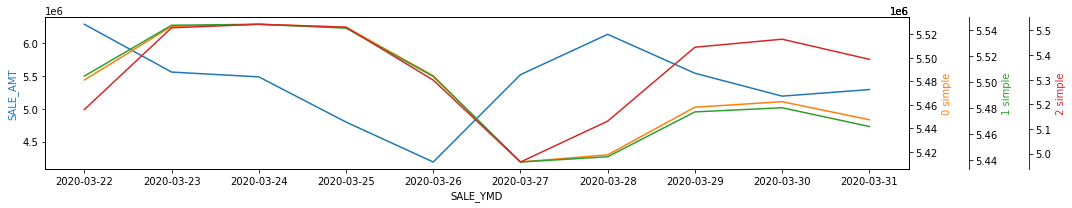

In [23]:
plot_model_graph(result2.tail(10), 'SALE_YMD', ['SALE_AMT','0 simple','1 simple','2 simple'])

In [24]:
result

,index,r2
0,0,0.119
1,1,0.119
2,2,0.073


Holt-Winter's Exponential Smoothing

In [25]:
holt_fit0=Holt(df_date_sum.SALE_AMT).fit(smoothing_level=0.8,smoothing_slope=0.3) #holt additive model
holt_fit1=Holt(df_date_sum.SALE_AMT,exponential=True).fit(smoothing_level=0.8,smoothing_slope=0.3) #holt exponential model
holt_fit2=Holt(df_date_sum.SALE_AMT,damped=True).fit(smoothing_level=0.8,smoothing_slope=0.3) #holt damped trend

In [26]:
result = pd.DataFrame(columns = ['index','r2'])
result2 = df_date_sum.copy()
y = result2.SALE_AMT
y_pred0 = holt_fit0.fittedvalues
y_pred1 = holt_fit1.fittedvalues
y_pred2 = holt_fit2.fittedvalues
#rmse0 = mean_squared_error(y, y_pred0)**0.5
#rmse1 = mean_squared_error(y, y_pred1)**0.5
#rmse2 = mean_squared_error(y, y_pred2)**0.5
r2_0 = r2_score(y,y_pred0)
r2_0 = r2_score(y,y_pred1)
r2_0 = r2_score(y,y_pred2)
result = result.append({'index': "{0:.0f}".format(0),'r2':"{0:.03f}".format(r2_0)}, ignore_index=True)
result = result.append({'index': "{0:.0f}".format(1),'r2':"{0:.03f}".format(r2_1)}, ignore_index=True)
result = result.append({'index': "{0:.0f}".format(2),'r2':"{0:.03f}".format(r2_2)}, ignore_index=True)
result2.insert(2, str(0)+" holt",y_pred0)
result2.insert(3, str(1)+" holt",y_pred1)
result2.insert(4, str(2)+" holt",y_pred2)

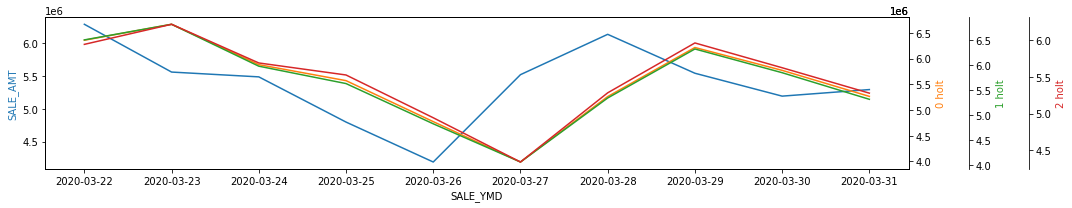

In [27]:
plot_model_graph(result2.tail(10), 'SALE_YMD', ['SALE_AMT','0 holt','1 holt','2 holt'])

In [28]:
result

,index,r2
0,0,-0.102
1,1,0.119
2,2,0.073
